In [144]:
"""Vehicles Routing Problem (VRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pylab
from matplotlib.pyplot import figure
import math
import pandas as pd
from scipy.spatial import distance


%matplotlib notebook
%matplotlib inline

sns.set(style="white", color_codes=True)


In [145]:
CARS =  5
POINTS = 50
STATION = 6
CAPACITY = 10000
TIME_END = 8 * 60 # минту # Допустим 60 км/ч


In [146]:
random.seed(41)
data = []
for i in range(POINTS):
    data.append( (random.randint(1,POINTS), random.randint(1,POINTS)) )
    
x = []
y = []
pandas_columns = ['points', 'money']
for i in data:
    val = str(i[0])+ ',' + str(i[1])
    if val in pandas_columns:
        new_x = random.randint(1,POINTS) 
        new_y = random.randint(1,POINTS) 
        x.append(new_x)
        y.append(new_y)
        val = str(new_x)+ ',' + str(new_y)
    else:        
        x.append(i[0])
        y.append(i[1])
        
        
    pandas_columns.append( val ) 
    


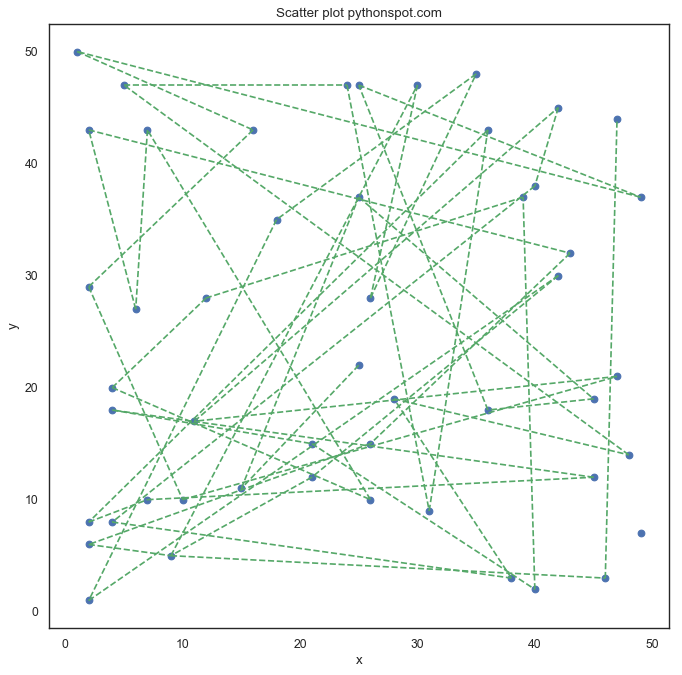

In [147]:
colors = (0,0,0)
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x, y)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')

for i in range(POINTS):
    try:
        plt.plot(
            (data[i][0], data[i+1][0]),
            (data[i][1], data[i+1][1]), 
            'g--'
        )
    except IndexError:
        a=1


plt.show()

In [148]:
raw_data = pd.DataFrame(columns=pandas_columns)
raw_data['points'] = pandas_columns[2:]


In [149]:
def getValues(row, clm):
    probka = random.random()
    A = row['points'].split(',')
    B = clm.split(',')
    dst = distance.euclidean((int(A[0]), int(A[1])), (int(B[0]), int(B[1])) )
    #return (dst, probka)
    return dst

def getRandomMoney(row):
    return random.randint(100, 10000) 

def create_data_model(raw_data):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = raw_data.drop(['money', 'center'], axis=1).as_matrix()
    data['num_vehicles'] = 5
    data['demands'] = list(raw_data['money'])
        
    data['vehicle_capacities'] = [30000, 30000, 30000, 30000, 30000]
    data['start_nodes'] = [0, 0, 0,0, 0]
    data['end_nodes'] = [0, 0, 0, 0, 0]
    return data
    # [END data_model]

In [150]:
def getAdjustedDistanceMatrix(x, p):
    if x['money'] == 0:
        return x[p] * 1000
    else:
        return x[p] / x['money'] * 1000
    

In [151]:
random.seed(42)
for p in pandas_columns[2:]:
    raw_data[p] = raw_data[['points',p]].apply(getValues,  axis=1, args = (p,) )

random.seed(42)
raw_data['money'] = raw_data[['money']].apply(getRandomMoney,  axis=1 )

for p in pandas_columns[2:]:
    raw_data[p] = raw_data[['money', p]].apply(getAdjustedDistanceMatrix,  axis=1 , args = (p,))


In [152]:
raw_data

,points,money,"25,22","15,11","25,37","45,19","36,18","25,47","49,37","1,50",...,"30,47","26,28","35,48","18,35","2,1","42,30","21,12","49,7","46,3","47,44"
0,"25,22",1924,0.000000,7.726647,7.796258,10.511304,6.083524,12.993763,14.709950,19.167452,...,13.251090,3.161519,14.478574,7.674024,16.187538,9.765226,5.597884,14.709950,14.719129,16.170841
1,"15,11",509,29.206422,0.000000,54.728441,60.998722,43.489084,73.404879,84.090116,81.408052,...,76.620825,39.780858,82.631595,47.518219,32.222435,64.862766,11.950418,67.258321,62.899059,90.309194
2,"25,37",4606,3.256622,6.047932,0.000000,5.841782,4.766500,2.171081,5.210595,5.925898,...,2.427343,1.965998,3.227544,1.580571,9.274863,3.991484,5.496739,8.341022,8.676179,5.012330
3,"45,19",4112,4.918227,7.550669,6.543591,0.000000,2.202185,8.368021,4.484214,13.089442,...,7.724893,5.112791,7.460049,7.632468,11.336442,2.772800,6.079767,3.076146,3.898643,6.099191
4,"36,18",3757,3.115438,5.891920,5.843625,2.410270,0.000000,8.255556,6.127689,12.622737,...,7.882402,3.764210,7.989529,6.590055,10.117955,3.571043,4.300105,4.532709,4.798445,7.514290
5,"25,47",2386,10.477787,15.659297,4.191115,14.421333,12.999214,0.000000,10.896899,10.136954,...,2.095557,7.974140,4.212018,5.822483,21.554721,10.076123,14.764388,19.550551,20.433565,9.305785
6,"49,37",1779,15.908906,24.059510,13.490725,10.364862,12.940826,14.614952,0.000000,27.953495,...,12.069090,13.883180,10.008147,17.461748,33.278831,5.564640,21.099859,16.863406,19.186114,4.092248
7,"1,50",9035,4.081702,4.586242,3.020995,5.957254,5.248879,2.677009,5.504069,0.000000,...,3.226869,3.685850,3.769648,2.509305,5.424483,5.049029,4.752830,7.132681,7.201903,5.134439
8,"16,43",1524,14.991679,21.007625,7.097542,24.700171,21.007625,6.462505,22.008543,10.861513,...,9.553950,11.829236,12.891655,5.410900,29.049795,19.074071,20.604092,32.044922,32.808399,20.351788
9,"2,29",9774,2.459753,2.271701,2.491466,4.516828,3.656142,2.988149,4.877838,2.150992,...,3.405631,2.457625,3.895935,1.748313,2.864743,4.093769,2.608461,5.309405,5.228947,4.853096


In [153]:
raw_data.set_index('points', inplace=True)

In [154]:
raw_data['center'] = 0
raw_data.loc[raw_data.index =='25,22', 'center'] =1
#raw_data.loc[data.index =='30,50', 'center'] =1
#raw_data.loc[data.index =='77,89', 'center'] =1
#raw_data.loc[data.index =='13,31', 'center'] =1
#raw_data.loc[data.index =='86,36', 'center'] =1
raw_data.loc[raw_data['center'] == 1, 'money'] = 0

In [155]:
data = create_data_model(raw_data)

/Users/u17230836/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [156]:
def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))


In [157]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(raw_data)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['start_nodes'],
                                           data['end_nodes'],
                                          )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    
    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    # Allow to drop nodes.
    penalty = 1000
    #for node in range(1, len(data['distance_matrix'])):
    #    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)
    
    # Allow to drop nodes.
    for node in range(1, len(data['distance_matrix'])):
        #print(list(raw_data['money'])[node])
        penalty = list(raw_data['money'])[node]
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)
    
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    return data, manager, routing, assignment


In [158]:
data_new, manager, routing, solution = main()

/Users/u17230836/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [159]:
print_solution(data_new, manager, routing, solution)

Dropped nodes: 9 13 14 19 20 22 23 25 33 34 36 44 45 49
Route for vehicle 0:
 0 Load(0) ->  10 Load(7012) ->  35 Load(8786) ->  7 Load(17821) ->  42 Load(22254) ->  11 Load(22874) ->  29 Load(29898) ->  0 Load(29898)
Distance of the route: 55m
Load of the route: 29898

Route for vehicle 1:
 0 Load(0) ->  21 Load(9028) ->  6 Load(10807) ->  47 Load(17108) ->  28 Load(19823) ->  16 Load(28202) ->  38 Load(29886) ->  0 Load(29886)
Distance of the route: 47m
Load of the route: 29886

Route for vehicle 2:
 0 Load(0) ->  40 Load(5735) ->  31 Load(10387) ->  26 Load(15044) ->  24 Load(22503) ->  39 Load(28484) ->  48 Load(29875) ->  0 Load(29875)
Distance of the route: 46m
Load of the route: 29875

Route for vehicle 3:
 0 Load(0) ->  1 Load(509) ->  12 Load(1097) ->  15 Load(5008) ->  30 Load(10682) ->  5 Load(13068) ->  8 Load(14592) ->  43 Load(15403) ->  2 Load(20009) ->  41 Load(30000) ->  0 Load(30000)
Distance of the route: 67m
Load of the route: 30000

Route for vehicle 4:
 0 Load(0) -

In [160]:
print_solution(data_new, manager, routing, solution)

Dropped nodes: 9 13 14 19 20 22 23 25 33 34 36 44 45 49
Route for vehicle 0:
 0 Load(0) ->  10 Load(7012) ->  35 Load(8786) ->  7 Load(17821) ->  42 Load(22254) ->  11 Load(22874) ->  29 Load(29898) ->  0 Load(29898)
Distance of the route: 55m
Load of the route: 29898

Route for vehicle 1:
 0 Load(0) ->  21 Load(9028) ->  6 Load(10807) ->  47 Load(17108) ->  28 Load(19823) ->  16 Load(28202) ->  38 Load(29886) ->  0 Load(29886)
Distance of the route: 47m
Load of the route: 29886

Route for vehicle 2:
 0 Load(0) ->  40 Load(5735) ->  31 Load(10387) ->  26 Load(15044) ->  24 Load(22503) ->  39 Load(28484) ->  48 Load(29875) ->  0 Load(29875)
Distance of the route: 46m
Load of the route: 29875

Route for vehicle 3:
 0 Load(0) ->  1 Load(509) ->  12 Load(1097) ->  15 Load(5008) ->  30 Load(10682) ->  5 Load(13068) ->  8 Load(14592) ->  43 Load(15403) ->  2 Load(20009) ->  41 Load(30000) ->  0 Load(30000)
Distance of the route: 67m
Load of the route: 30000

Route for vehicle 4:
 0 Load(0) -

In [161]:
max_route_distance = 0
vhc = {}
for vehicle_id in range(data_new['num_vehicles']):    
    index = routing.Start(vehicle_id)
    vhc[vehicle_id] =[]
    plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
    route_distance = 0
    while not routing.IsEnd(index):
        
        #vhc[index].append(manager.IndexToNode(index))
        plan_output += ' {} -> '.format(manager.IndexToNode(index))
        vhc[vehicle_id].append(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(
        previous_index, index, vehicle_id)
    vhc[vehicle_id].append(manager.IndexToNode(index))
    plan_output += '{}\n'.format(manager.IndexToNode(index))
    plan_output += 'Distance of the route: {}m\n'.format(route_distance)
    #print(plan_output)
    max_route_distance = max(route_distance, max_route_distance)

In [162]:
clss = {} 
clss[0] = 'b--'
clss[1] = 'g--'
clss[2] = 'r--' 
clss[3] = 'c--' 
clss[4] = 'm--' 
clss[5] = 'y--' 


In [163]:
raw_data.loc['25,22']['money']

0.0

In [164]:
def drawResult(x,y,new_data, show_text =False, show_money = False):
    colors = (0,0,0)
    figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y)

    plt.title('Scatter plot pythonspot.com')
    plt.xlabel('x')
    plt.ylabel('y')
    
    if show_money == True:
        for v in vhc:
            for i_x, i_y in zip(x, y):
                m = str(raw_data.loc['{},{}'.format(i_x, i_y)]['money'])
                plt.text(i_x, i_y, m)
    
    if show_text == True:
        for i_x, i_y in zip(x, y):
            plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y))

    for v in vhc:
        clr_cur = clss[v]
        for  idx, elem in enumerate(vhc[v]):    
            try:
                xx1,yy1 = raw_data.index[vhc[v][idx]].split(',')
                xx2,yy2 = raw_data.index[vhc[v][idx+1]].split(',')
                xx1 = int(xx1)
                yy1 = int(yy1)
                xx2 = int(xx2)
                yy2 = int(yy2)
                plt.plot(
                    (xx1, xx2),
                    (yy1, yy2), 
                    clr_cur
                )
            except IndexError:
                a=1
        
    plt.show()

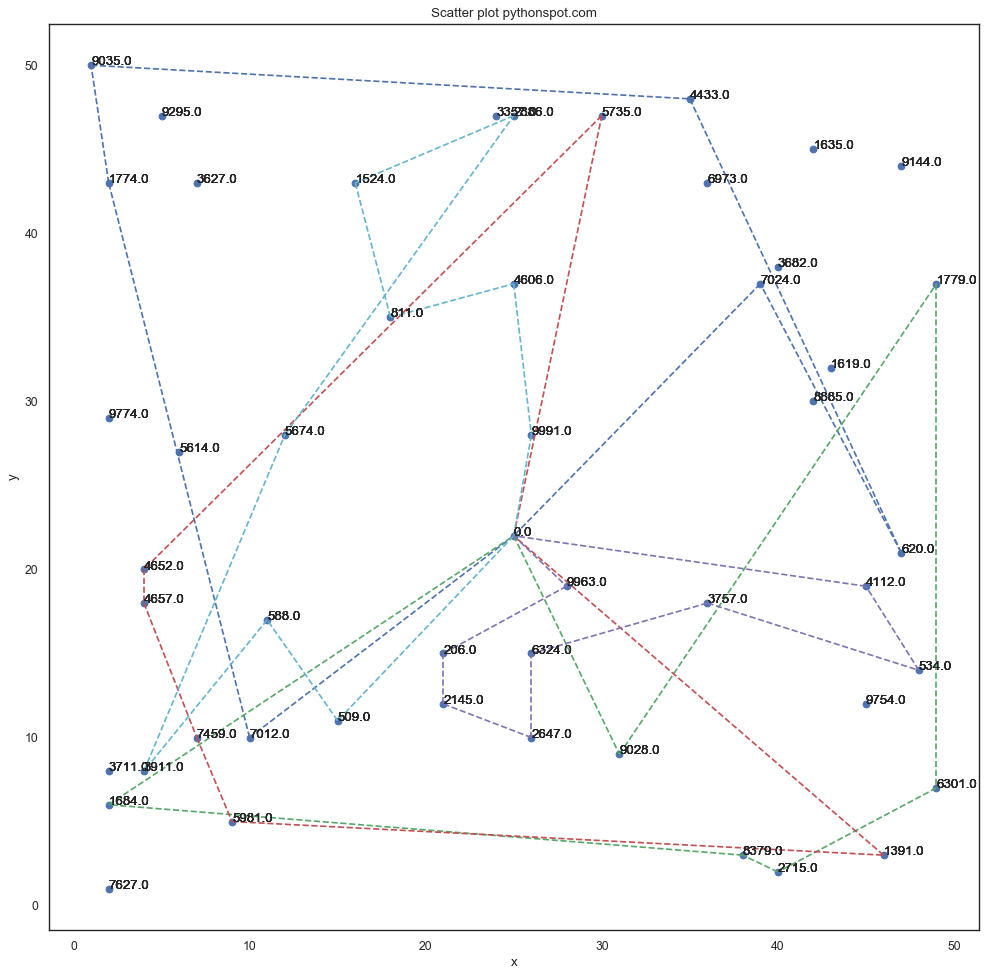

In [165]:
drawResult(x, y, raw_data, False, True)